
#### ELE680 - Deep Neural Networks | Project Group 7
---
## Training RL Agents in Interactive Continuous Control Environments
#### Participants:

| Name | Student Nr |
| --- | --- |
| Katerina Kolarikova | |
| Maroof Mushtaq | |
| Bawfeh Kingsley Kometa | 271961 |

---


### Tasks: Mountain Car Continuous
In this exercise, we shall solve the **[OpenAI Gym - Mountain Car Continuous](https://gymnasium.farama.org/environments/classic_control/mountain_car_continuous/)** problem using **Q Learning with Experience Replay**. 

![title](https://gymnasium.farama.org/_images/mountain_car_continuous.gif)

The `Mountain Car` is a control environment defined in the OpenAI's Gym framework, initially defined by [Andrew Moore](https://www.cl.cam.ac.uk/techreports/UCAM-CL-TR-209.pdf) in his PhD work. It describes a deterministic MDP whereby a car is stochastically placed at the bottom of a sinusoidal valley. Actions are applied in one of two directions to enable the car get to a target point at the top of the valley.  The environment definition comes in two versions: one with discrete actions and the other with continuous actions. In this work, we shall only consider the continuous version (`MountainCarContinuous-v0`). 

The state (observation) space is represented by a 2D array comprised of two attributes--the _position_ and _velocity_ respectively. Actions are represented by scalars selected from the interval $[-1,1]$ and multiplied by a power of $0.0015$. For a given action, transition from current state to next is given by the following mathematical formulas:
\begin{align}
\text{velocity}_{t+1} &\coloneqq \text{velocity}_{t} + 0.0015 * \text{action} - 0.0025 * \cos(3 * \text{position}_{t}) \\
\text{position}_{t+1} &\coloneqq \text{position}_{t} + \text{velocity}_{t+1}
\end{align}
where HP represents the car's engine horsepower.

The complete details regarding the environment, state space, action space, state transition and reward mechanisms, termination conditions and other parameters are in the openAI Gym [documention](https://gymnasium.farama.org/environments/classic_control/mountain_car_continuous/). The game is **considered solved when the target is hit**.

In this exercise we shall: 
- Implement an deep neural network (agent) that optimizes the Q-values required to maximize total discounted average rewards in the long term.
- Design training loop to learn from the environment using Q-learning techniques with experience replay
- Report on the training loss and cumulative total reward received over time


In [96]:
for name in dir():
    if not (name.startswith('_') or name.endswith('_')):
        del globals()[name]

In [97]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [98]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last" # all | last | last_expr | none 

## 1. Environment Setup
---

In [99]:
import os
import numpy as np
from matplotlib import pyplot as plt
import random
# import pygame
# import cv2
import gymnasium as gym

RANDOM_STATE = 1234
ENV_NAME = 'MountainCarContinuous-v0'
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
# EPOCHS  = 100 # works for experience replay no target net
EPOCHS  = 400


In [100]:
# Ensure that environment exists
assert ENV_NAME in gym.envs.registry.keys()

# Create an instance of enviroment
env = gym.make(ENV_NAME)

# Verify essential properties of the environment
state = env.reset()[0]
print("Initial state: [position: {:.2f}, velocity: {:.2f}]".format(*state))
print("Observation space: {}".format(env.observation_space))
print(f"Action space: {env.action_space}")
a = env.action_space.sample()
print("\nOutput from applying action {} on environment:\n(state:".format(a) \
      + "\t{}\nreward: {}\nterminated: {}\ntruncated: {}\ninfo: {})".format(*env.step(a)))


Initial state: [position: -0.59, velocity: 0.00]
Observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Action space: Box(-1.0, 1.0, (1,), float32)

Output from applying action [-0.07819345] on environment:
(state:	[-5.8621323e-01  3.5215588e-04]
reward: -0.0006114215385811195
terminated: False
truncated: False
info: {})


In [101]:
env = gym.wrappers.RecordVideo(
    env=gym.make(ENV_NAME, render_mode="rgb_array"), 
    video_folder="./MC_Continuous/", 
    name_prefix="mc_episodes", 
    episode_trigger=lambda x: x % 10 == 0,
    # episode_trigger=lambda x: False,
    # video_length=200,
    # disable_logger=True
)

# Set non-positional agent class args
parameters = dict(
    epsilon=0.01, 
    max_epsilon=1,
    gamma=0.99, 
    num_actions=10,
    # path='./MC_Continuous/',
    # recording_range=range(EPOCHS-100, EPOCHS), 
    seed=RANDOM_STATE,
)
# Set training parameters
train_parameters = dict(
    epochs=EPOCHS, 
    learningRate=0.001, 
    maxMoves=100, 
    memorySize=10000, 
    batchSize=128, 
    render=True,
)
# Set plotting parameters
plot_parameters = dict(
    grid_on=True, 
    m_averages=EPOCHS // 10, 
    # metric=None
)

## 2. Experience Replay
---

In [102]:
# # import torch
# from MC_Continuous.DQL_experience import *
# torch.seed = RANDOM_STATE
# torch.manual_seed(RANDOM_STATE)

### 2.1 Creating the agent instance

In [103]:
# agent = experience_Agent(env, **parameters)
# agent.model

### 2.2 Train the agent

In [104]:
# history = agent.train(**train_parameters)

### 2.3 Plot the training losses and rewards

In [105]:
# info = agent.plot_history(history, **plot_parameters)

### 2.4 Test the agent using the trained model


In [106]:
# info = agent.test(numTest=10, render=True, maxMoves=100,
#                 #   saved_model_path='./MC_Continuous/saved_model.pt'
#                   ) 

In [107]:
# for d in info:
#     plt.plot(info[d]['actions'])
# plt.show()

## 3. Experience Replay with secondary Target Network
---

In [108]:
# import torch
from MC_Continuous.DQL_target import *
torch.seed = RANDOM_STATE
_ = torch.manual_seed(RANDOM_STATE)


### 3.1 Create neural Agent

In [109]:
agent2 = target_Agent(env, **parameters)

### 3.2 Train the agent

In [110]:
history2 = agent2.train(**train_parameters, syncFreq=int(EPOCHS/100))


epoch 0: 	error = nan, cumulative reward = -2.72 (in 100 moves)
Moviepy - Building video /Users/bawfeh78/Downloads/ELE680/ELE680/RL/MC_Continuous/mc_episodes-episode-0.mp4.
Moviepy - Writing video /Users/bawfeh78/Downloads/ELE680/ELE680/RL/MC_Continuous/mc_episodes-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/bawfeh78/Downloads/ELE680/ELE680/RL/MC_Continuous/mc_episodes-episode-0.mp4
epoch 40: 	error = 7.25e-02, cumulative reward = -2.44 (in 100 moves)
epoch 80: 	error = 1.57e-01, cumulative reward = -1.49 (in 100 moves)
epoch 120: 	error = 2.14e+00, cumulative reward = 99.97 (in 1 moves)
epoch 160: 	error = 3.53e+01, cumulative reward = 99.97 (in 1 moves)
epoch 200: 	error = 3.25e+01, cumulative reward = 99.97 (in 1 moves)
epoch 240: 	error = 5.23e+01, cumulative reward = 99.97 (in 1 moves)
epoch 280: 	error = 4.35e+01, cumulative reward = 99.95 (in 1 moves)
epoch 320: 	error = 3.98e+01, cumulative reward = 99.95 (in 1 moves)
epoch 360: 	error = 2.73e+01, cumulative reward = 99.95 (in 1 moves)
Wins 290 out of 400 plays!
Saved episode 0!


### 3.3 Plot the training losses and rewards

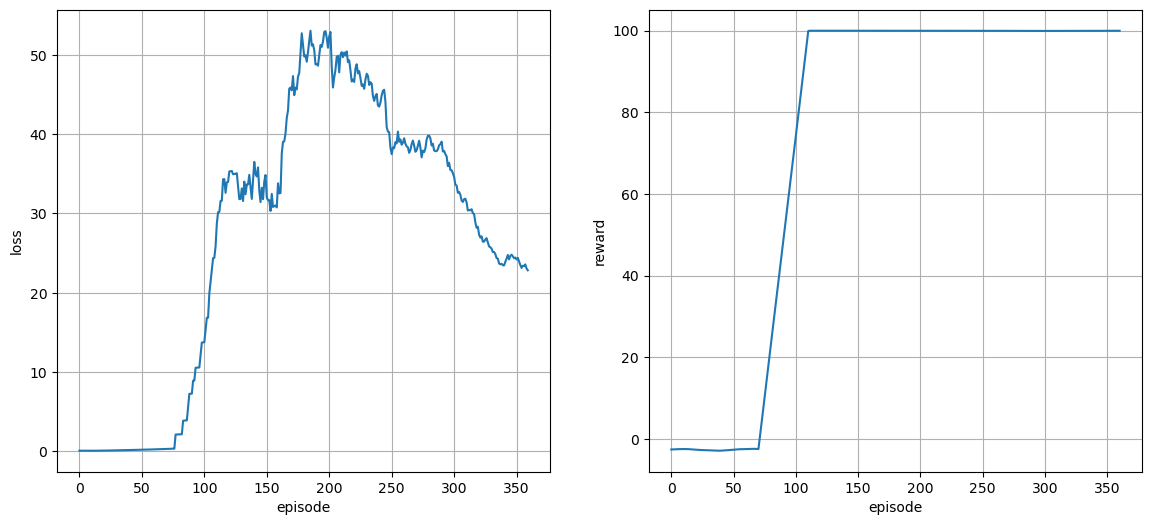

In [111]:
agent2.plot_history(history2, **plot_parameters)

### 3.4 Test the agent using the trained model


In [112]:
info2 = agent2.test(numTest=10, render=True, maxMoves=100, 
                #   saved_model_path='./MC_Continuous/saved_model_target.pt'
                  ) 

Test episode 0: total rewards = 99.99 (in 1/100 moves)
Test episode 1: total rewards = 99.99 (in 1/100 moves)
Test episode 2: total rewards = 99.99 (in 1/100 moves)
Test episode 3: total rewards = 99.99 (in 1/100 moves)
Test episode 4: total rewards = 99.99 (in 1/100 moves)
Test episode 5: total rewards = 99.99 (in 1/100 moves)
Test episode 6: total rewards = 99.99 (in 1/100 moves)
Test episode 7: total rewards = 99.99 (in 1/100 moves)
Test episode 8: total rewards = 99.99 (in 1/100 moves)
Test episode 9: total rewards = 99.99 (in 1/100 moves)
  Summary
---------------
plays: 10 
wins: 10
mean (rewards): 99.991 
std (rewards): 0.0


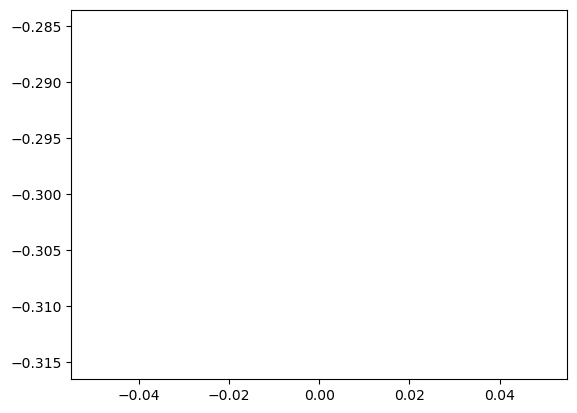

In [113]:
for d in info2:
    plt.plot(info2[d]['actions'])
plt.show()